In [1]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from keras.optimizers import Adam, SGD
from keras import optimizers

import os

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

In [44]:
import GPUtil
from tabulate import tabulate  

def Graphics_info():
    gpus=  GPUtil.getGPUs()
    list_gpus=[]
    for gpu in gpus:
        gpu_id = gpu.id
        gpu_name = gpu.name
        gpu_load = f"{gpu.load*100}%"
        gpu_free_memory = f"{gpu.memoryFree}MB"
        gpu_used_memory = f"{gpu.memoryUsed}MB"
        gpu_total_memory = f"{gpu.memoryTotal}MB"
        gpu_temperature = f"{gpu.temperature}`C"
        gpu_uuid = gpu.uuid
        list_gpus.append((gpu_id,gpu_name,gpu_load,gpu_free_memory,gpu_used_memory,gpu_total_memory,
                          gpu_temperature,gpu_uuid))
        
        return(str(tabulate(list_gpus,headers = ("ID","Name","Load","Free Memory","Used Memory",
                                                 "Total Memory","Temperature","UUID"),tablefmt="pretty")))
    
if __name__ == "__main__":
    print(Graphics_info())

+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+
| ID |         Name         | Load | Free Memory | Used Memory | Total Memory | Temperature |                   UUID                   |
+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+
| 0  | Tesla P100-PCIE-16GB | 0.0% |   743.0MB   |  15537.0MB  |  16280.0MB   |   37.0`C    | GPU-6a75575f-7eca-51e3-3768-a099bb9c9783 |
+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+


In [2]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [4]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df_data.shape)

(220025, 2)


In [5]:
df_data['label'].value_counts()


0    130908
1     89117
Name: label, dtype: int64

In [6]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

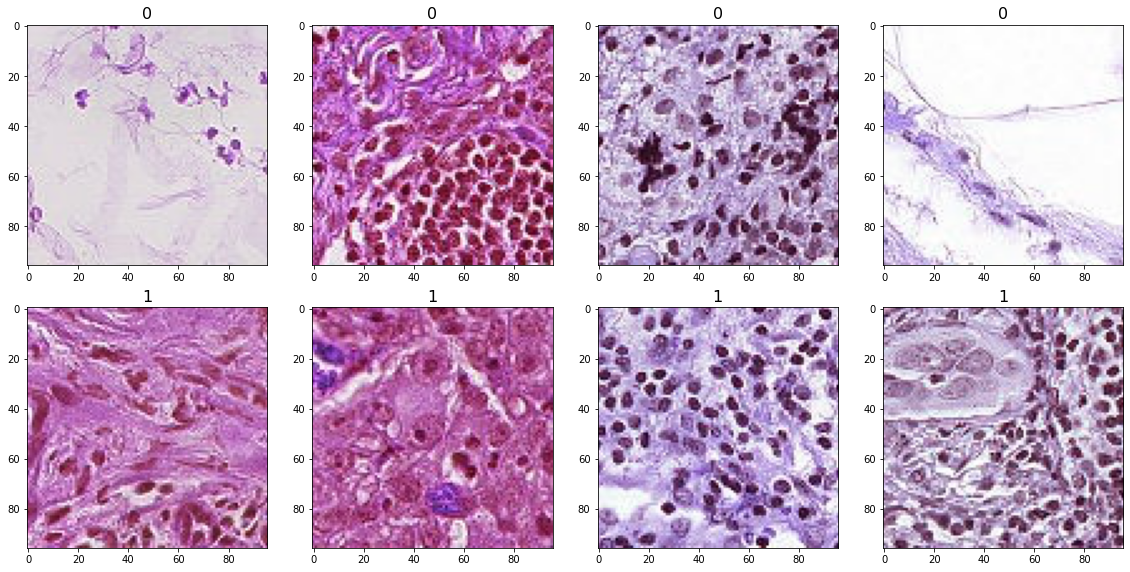

In [7]:
import cv2

IMAGE_PATH = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [8]:
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000 
IMAGE_SIZE=96

In [9]:
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [10]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 87704 to 133700
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      160000 non-null  object
 1   label   160000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [11]:
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=df_data['label'])

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [12]:
import shutil
shutil.rmtree('main', ignore_errors=True)

# Create directory
os.mkdir('main')

# Create subfolder for train and val images
os.mkdir(os.path.join('main', 'train'))
os.mkdir(os.path.join('main', 'val'))

# Create subfolders for true positive and true negative in train
os.mkdir(os.path.join('main','train','true_positive'))
os.mkdir(os.path.join('main','train','true_negative'))      
         
# Create subfolders for true positive and true negative in val
os.mkdir(os.path.join('main','val','true_positive'))
os.mkdir(os.path.join('main','val','true_negative'))

In [13]:
train_df_1 = df_train[df_train["label"] == 1]['id'].tolist()
train_df_1 = [name + ".tif" for name in train_df_1]

# Save all train true negativeto names list and add .tif
train_df_0 = df_train[df_train["label"] == 0]['id'].tolist()
train_df_0 = [name + ".tif" for name in train_df_0]

# Save all val true positive "id" to list and add .tif
val_df_1 = df_val[df_val["label"] == 1]['id'].tolist()
val_df_1 = [name + ".tif" for name in val_df_1]

# Save all val true negative "id" to list
val_df_0 = df_val[df_val["label"] == 0]['id'].tolist()
val_df_0 = [name + ".tif" for name in val_df_0]

In [14]:
import shutil
import os
from tqdm import tqdm

def transfer(source,destination,files):
    for image in tqdm(files):
        # source path to image
        src = os.path.join(source,image)
        dst = os.path.join(destination,image)
        # copy the image from the source to the destination
        shutil.copyfile(src,dst)
        
# transfer
transfer('../input/histopathologic-cancer-detection/train','main/train/true_positive',train_df_1)
transfer('../input/histopathologic-cancer-detection/train','main/train/true_negative',train_df_0)
transfer('../input/histopathologic-cancer-detection/train','main/val/true_positive',val_df_1)
transfer('../input/histopathologic-cancer-detection/train','main/val/true_negative',val_df_0)

100%|██████████| 8000/8000 [01:11<00:00, 111.82it/s]


In [15]:
print("Trainig Negative : "+str(len(os.listdir('./main/train/true_negative'))))
print("Trainig Positive : "+str(len(os.listdir('./main/train/true_positive'))))

print("Validation Negative : "+str(len(os.listdir('./main/val/true_negative'))))
print("Validation Positive : "+str(len(os.listdir('./main/val/true_positive'))))

Trainig Negative : 72000
Trainig Positive : 72000
Validation Negative : 8000
Validation Positive : 8000


In [18]:
train_path = './main/train'
valid_path = './main/val'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 16
val_batch_size = 16


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print("Train Steps = " +str(train_steps))
print("Validation Steps = " +str(val_steps))

Train Steps = 9000.0
Validation Steps = 1000.0


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation 
train_datagen = ImageDataGenerator(
                rescale=1./255,
                vertical_flip=True,
                horizontal_flip=True,
                rotation_range=90,
                shear_range=0.05)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory('main/train',
                                            target_size=(96,96),
                                            batch_size=train_batch_size,
                                            class_mode='categorical')

Found 144000 images belonging to 2 classes.


In [21]:
val_generator = test_datagen.flow_from_directory('main/val',
                                                  target_size=(96,96),
                                            batch_size=val_batch_size,
                                            class_mode='categorical')

Found 16000 images belonging to 2 classes.


In [22]:
test_generator = test_datagen.flow_from_directory('main/val',
                                            target_size=(96,96),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

Found 16000 images belonging to 2 classes.


In [23]:
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16_model = VGG16(include_top = False,
                    input_shape = (96,96,3),
                    weights = 'imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [24]:
model = Sequential()
#for layer in vgg16_model.layer:
#    model.add(layer)    
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [25]:
for layer in vgg16_model.layers[:-12]:
    layer.trainable = False
    
for layer in vgg16_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4c1c752b50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c28e6e690> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c24dbaa90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4c1c6947d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c1c69bb50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c1c69e710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4c1c42c790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c1c69b090> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c1c694510> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4c1c42fe90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4c1c434050> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

In [26]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.SGD(lr=0.00001, momentum=0.95),metrics=['accuracy'])

In [27]:
history = model.fit_generator(
                    train_generator, 
                    steps_per_epoch  = train_steps, 
                    validation_data  = val_generator,
                    validation_steps = val_steps,
                    epochs           = 5, 
                    verbose          = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
9000/9000 [==============================] - 670s 74ms/step - loss: 0.5186 - accuracy: 0.7509 - val_loss: 0.3312 - val_accuracy: 0.8546
Epoch 2/5
9000/9000 [==============================] - 625s 69ms/step - loss: 0.3373 - accuracy: 0.8566 - val_loss: 0.2664 - val_accuracy: 0.8882
Epoch 3/5
9000/9000 [==============================] - 609s 68ms/step - loss: 0.2940 - accuracy: 0.8786 - val_loss: 0.2684 - val_accuracy: 0.8865
Epoch 4/5
9000/9000 [==============================] - 617s 69ms/step - loss: 0.2715 - accuracy: 0.8902 - val_loss: 0.2364 - val_accuracy: 0.9029
Epoch 5/5
9000/9000 [==============================] - 583s 65ms/step - loss: 0.2481 - accuracy: 0.8998 - val_loss: 0.2281 - val_accuracy: 0.9061


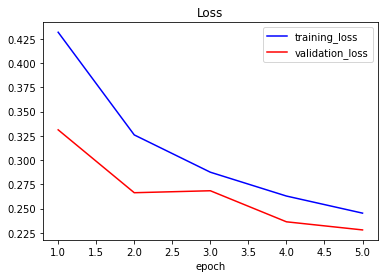

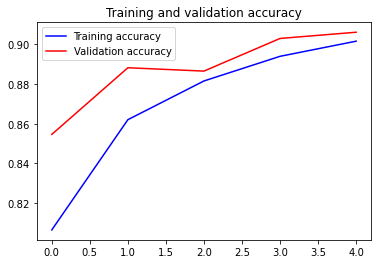

In [28]:
import matplotlib.pyplot as plt
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [29]:
val_predict = model.predict_generator(test_generator, steps=len(df_val), verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16000/16000 [==============================] - 68s 4ms/step


ROC area is: 0.9060625000000001


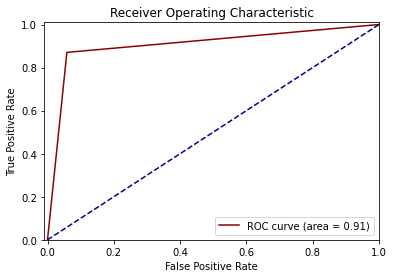

In [30]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, val_predict.argmax(axis=1))   
# Compute ROC area
print("ROC area is: " + str(auc(fpr, tpr)))

plt.figure()
plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [34]:
test_labels = test_generator.classes
assert(test_labels.shape == (16000,))

In [37]:
cm = confusion_matrix(test_labels, val_predict.argmax(axis=1))
test_generator.class_indices

{'true_negative': 0, 'true_positive': 1}

In [38]:
print(cm)

[[7533  467]
 [1036 6964]]


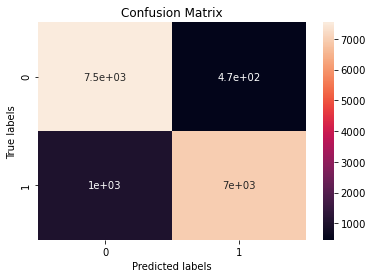

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [42]:
from sklearn.metrics import classification_report

y_pred_binary = val_predict.argmax(axis=1)

y_true = test_generator.classes


report = classification_report(y_true, y_pred_binary)

print(report)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8000
           1       0.94      0.87      0.90      8000

    accuracy                           0.91     16000
   macro avg       0.91      0.91      0.91     16000
weighted avg       0.91      0.91      0.91     16000



In [54]:
import visualkeras
visualkeras.layered_view(model)